<a href="https://colab.research.google.com/github/vladlee098/kaggle/blob/master/household_power_consumption_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp '/content/gdrive/My Drive/Colab Notebooks/data/household_power_consumption.zip' household_power_consumption.zip

In [5]:
!unzip \*.zip

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.csv  


In [0]:
import os
import sys
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  
import seaborn as sns  

import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

In [0]:
#!pip install mxnet
#!pip install gluonts

The description of data can be found here: [link text](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)

##Attribute Information: 

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corres

In [5]:
df = pd.read_csv('household_power_consumption.csv', sep=',', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [0]:
# filling nan with mean in any columns

for j in range(0,7):        
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [8]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

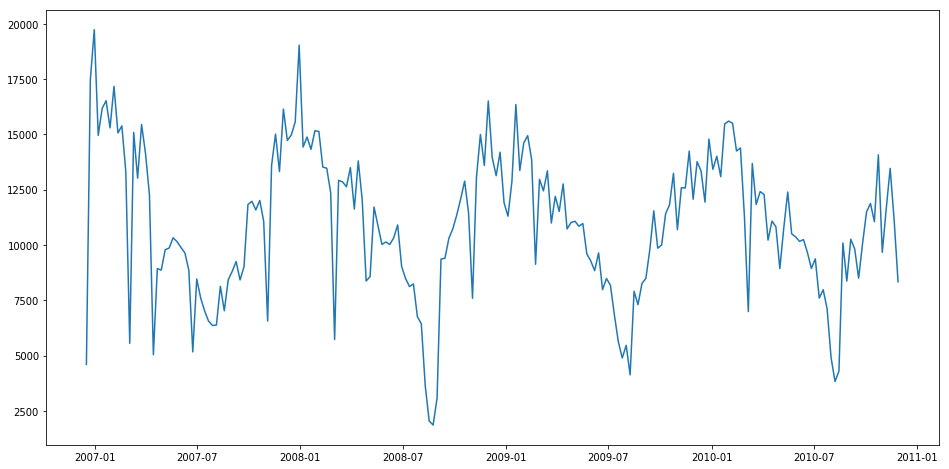

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## resample 

weekly_sum = df.resample('W').sum()
plt.figure(figsize=(16,8))
plt.plot(weekly_sum.index, weekly_sum['Global_active_power'].values)
plt.show()

In [11]:
weekly_sum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2006-12-17 to 2010-11-28
Freq: W-SUN
Data columns (total 7 columns):
Global_active_power      207 non-null float64
Global_reactive_power    207 non-null float64
Voltage                  207 non-null float64
Global_intensity         207 non-null float64
Sub_metering_1           207 non-null float64
Sub_metering_2           207 non-null float64
Sub_metering_3           207 non-null float64
dtypes: float64(7)
memory usage: 12.9 KB


In [0]:
weekly_sum.to_csv('household_power_consumption_weekly.csv')
!cp household_power_consumption_weekly.csv '/content/gdrive/My Drive/Colab Notebooks/data/household_power_consumption_weekly.csv' 

# Time-Series Forecasting Using Deep Learning

##GluonTS Introduction


##GluonTS

Gluon toolkit for time series modeling using MXNET
Build custom time series models (components for feature engineering, calendar features, etc)
Support various time series use cases, i.e., classification or anomaly detection
Pre-built models (Deep Learning, DeepAR, RNN, etc)
Model evaluation and visualization
Synthetic and real-world datasets

In [0]:
import mxnet as mx
from mxnet import gluon
from gluonts.model.r_forecast import RForecastPredictor

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import pandas as pd
import matplotlib.pyplot as plt
import json

from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

In [15]:
start = pd.Timestamp("2006-12-17", freq='W')
train_ds = [{'target': weekly_sum[column].head(-39).values, 'start': start} for column in weekly_sum]
test_ds = [{'target': weekly_sum[column].values, 'start': start} for column in weekly_sum]

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[30,30],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1E-3, 
                    hybridize=False, 
                    num_batches_per_epoch=50
                   )
)

predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 1203
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 118.24it/s, avg_epoch_loss=11]
INFO:root:Epoch[0] Elapsed time 0.427 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=10.963492
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 124.48it/s, avg_epoch_loss=10.3]
INFO:root:Epoch[1] Elapsed time 0.405 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=10.303698
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 111.69it/s, avg_epoch_loss=10.2]
INFO:root:Epoch[2] Elapsed time 0.451 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=10.237341
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 108.85it/s, avg_epoch_loss=10.3]
INFO:root:Epoch[3] Elapsed time 0.464 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=10.276153
INFO:root:Epoch[4] Learnin

In [17]:
# This function returns generators
forecast_it, ts_it = make_evaluation_predictions(
    test_ds, 
    predictor=predictor, 
    num_eval_samples=200)

#  Convert these generators to lists to ease the subsequent computations
forecasts_DNN = list(forecast_it)
tss_DNN = list(ts_it)

len(tss_DNN)
f_entry = forecasts_DNN[0]
tss_DNN[0].head(10)

,0
2006-12-17,4599.636000
2006-12-24,17479.311230
2006-12-31,19738.701230
2007-01-07,14961.068000
2007-01-14,16177.425615
2007-01-21,16525.666000
2007-01-28,15295.671615
2007-02-04,17172.372000
2007-02-11,15068.946000
2007-02-18,15385.376000


In [18]:
print(f"Frequency of the time series: {f_entry.freq}")
print(f"Start date of the forecast window: {f_entry.start_date}")
print(f"Number of sample paths: {f_entry.num_samples}")
print(f"Dimension of samples: {f_entry.samples.shape}")

#Compute the mean or a given quantile of the forecast
print(f"Mean of the future window:\n {f_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {f_entry.quantile(0.5)}")

Frequency of the time series: 1W
Start date of the forecast window: 2010-03-07 00:00:00
Number of sample paths: 200
Dimension of samples: (200, 39)
Mean of the future window:
 [13192.955  12739.1    12195.224  11757.503  12148.963  11546.822
 11269.145  11483.218  10182.131  10592.454  10234.359   9198.956
  8644.527   8415.926   9102.409   7928.866   7955.359   7440.196
  7088.308   6936.458   6994.348   6767.753   6921.0737  7763.912
  8202.398   8037.819   8697.142   9102.774  10000.133   9946.595
 11430.296  11026.051  11488.256  11791.326  11735.903  12708.617
 12840.111  12759.517  13013.755 ]
0.5-quantile (median) of the future window:
 [13109.436  12849.719  12191.117  11809.662  12159.853  11589.274
 11323.922  11765.526  10264.966  10045.868  10030.234   9338.11
  8643.456   8671.98    9046.048   7925.3994  7860.637   7541.3447
  7335.08    6958.9023  7113.8247  6669.177   6809.2866  7557.397
  8594.661   7971.525   8761.999   8910.115  10055.18   10040.252
 11286.701  11098.

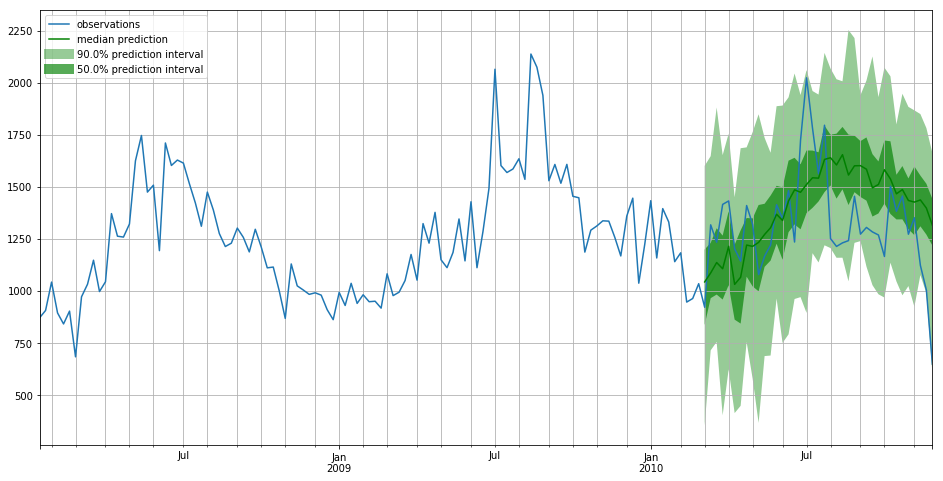

In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
id = 1
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])    

In [25]:
tss_DNN.head()

AttributeError: ignored

In [20]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN, item_metrics_DNN = evaluator(iter(tss_DNN), iter(forecasts_DNN), num_series=len(test_ds))

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 137.19it/s]


In [21]:
item_metrics_DNN.head()

,Coverage[0.5],MASE,MSE,MSIS,QuantileLoss[0.5],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.384615,0.843485,3.512184e+06,33.739416,5.401100e+04,5.401100e+04,9.904302e+03,3.862678e+05,NaN,0.152536,1641.874793
1,0.589744,1.437958,6.787922e+04,57.518323,8.307314e+03,8.307314e+03,1.324781e+03,5.166644e+04,NaN,0.159887,148.132304
2,0.230769,5.125348,2.499828e+10,205.013900,3.883095e+06,3.883095e+06,2.412369e+06,9.408238e+07,NaN,0.042892,19426.301742
3,0.410256,0.861257,6.169449e+07,34.450299,2.300784e+05,2.300784e+05,4.200621e+04,1.638242e+06,NaN,0.152373,6849.804947
4,0.538462,0.774354,2.379279e+07,30.974161,1.341985e+05,1.341985e+05,9.353703e+03,3.647944e+05,NaN,0.427449,4443.688153


In [22]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="W", prediction_length=39)

forecast_it, ts_it = make_evaluation_predictions(test_ds,predictor=seasonal_predictor_1W, num_eval_samples=200)
forecasts_naive = list(forecast_it)
tss_naive = list(ts_it)

agg_metrics_naive, item_metrics_naive = evaluator(iter(tss_naive), iter(forecasts_naive), num_series=len(test_ds))

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 163.75it/s]


In [24]:
agg_metrics_naive

{'Coverage[0.5]': 0.5787545787545787,
 'MAE_Coverage': 0.0787545787545787,
 'MASE': 1.2838790976550938,
 'MSE': 2142181060.9522564,
 'MSIS': 51.35516390620375,
 'ND': 0.023897964933499667,
 'NRMSE': 0.12694442471831774,
 'QuantileLoss[0.5]': 2378690.962059124,
 'RMSE': 46283.701893347476,
 'abs_error': 2378690.962059124,
 'abs_target_mean': 364598.14596858673,
 'abs_target_sum': 99535293.84942417,
 'mean_wQuantileLoss': 0.023897964933499667,
 'sMAPE': 0.24279525280696057,
 'seasonal_error': 6891.0687924144195,
 'wQuantileLoss[0.5]': 0.023897964933499667}

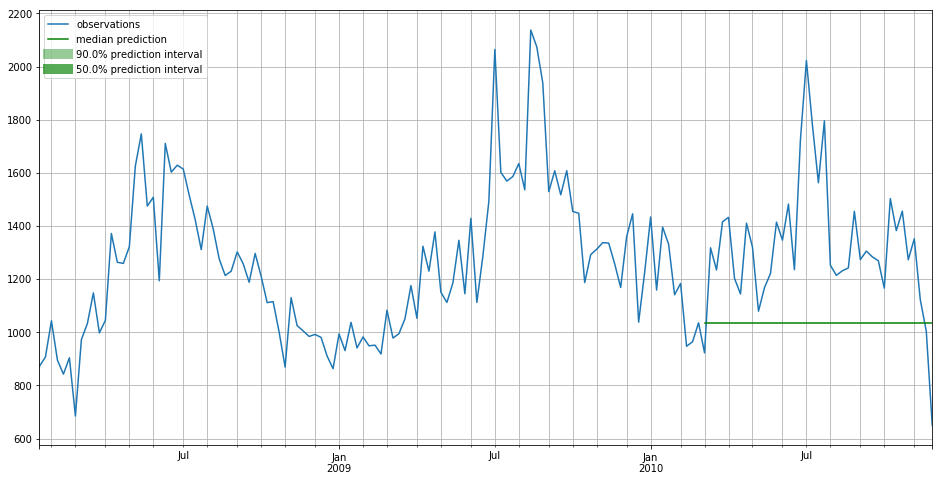

In [23]:
id = 1
plot_prob_forecasts(tss_naive[id], forecasts_naive[id])